# Classifying customer complaints with Watson NLP

This notebook demonstrates how to train different text classifiers using Watson NLP. The classifiers predict the product group from the text of a customer complaint. This could be used, for example to route a complaint to the appropriate staff member. 

The data that is used in this notebook is taken from the Consumer Complaint Database that is published by the Consumer Financial Protection Bureau (CFPB), a U.S. government agency. The Consumer Complaint Database is a collection of complaints about consumer financial products and services that the CFPB sent to companies for response.  A complaint contains the consumer’s narrative description of their experience if the consumer opted to share this information publicly and after the Bureau has removed all personal information. In this notebook, you will focus on complaints that contain this narrative description to show how to use Watson NLP.

The data is publicly available at https://www.consumerfinance.gov/data-research/consumer-complaints/.

## What you'll learn in this notebook

Watson NLP implements state-of-the-art classification algorithms from three different families: 
- Classic machine learning using SVM (Support Vector Machines)
- Deep learning using CNN (Convolutional Neural Networks)
- A transformer-based algorithm using the Google BERT multilingual model 

Watson NLP also offers an easy to use _ensemble classifier_ which combines different classification algorithms and a majority voting.

In this notebook, you'll learn how to:

- **Prepare your data** so that it can be used as training data for the Watson NLP classification algorithms.
- **Train a custom SVM model** using `watson_nlp.blocks.classification.SVM`. SVM stands for Support Vector Machines. It's an established classification method. We will run it based on USE (Universal Sentence Encoder) embeddings of the input text.
- **Train a VotingEnsemble** using `watson_nlp.workflows.classification.Ensemble`. The Ensemble model combines three classification models: CNN, SVM with TF-IDF and SVM with USE (Universal Sentence Encoder). It computes the weighted mean of classification predictions using confidence scores.
- **Store and load classification models** as an asset of a Watson Studio project.
- **Score data and compare model quality** by running the models on test data and using the built-in quality evaluation and building a custom confusion matrix.


## Table of Contents


1. [Before you start](#beforeYouStart)
2. [Load the complaint data](#loadData)
3. [Prepare training and test data](#prepareData)
4. [Train a SVM classification model with Watson NLP](#svm)
5. [Train an ensemble classification model with Watson NLP](#ensemble)
6. [Store and load classification models](#storeLoad)
7. [Classify test data and compare model quality](#scoring)
8. [Summary](#summary)


<a id="beforeYouStart"></a>
## Before you start

Note that you can step through the notebook execution cell by cell, by selecting Shift-Enter. Or you can execute the entire notebook by selecting **Cell -> Run All** from the menu.



Begin by importing and initializing some helper libs that are used throughout the notebook.

In [1]:
import pandas as pd
# we want to show large text snippets to be able to explore the relevant text
pd.options.display.max_colwidth = 400

import json
import seaborn as sn
import matplotlib.pyplot as plt

In [20]:
import watson_nlp

from watson_core.data_model.streams.resolver import DataStreamResolver
from watson_core.toolkit import fileio
from watson_nlp.blocks.classification.svm import SVM

<a id="loadData"></a>
## Load the complaint data

The data can be downloaded via an API from https://www.consumerfinance.gov/data-research/consumer-complaints/. The data contains one month of data and only those complaints that contain the consumer narrative text. The data is exported in CSV format. The URL to retrieve this data looks like this:

In [3]:
url = "https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/?date_received_max=2021-03-30&date_received_min=2021-02-28&field=all&format=csv&has_narrative=true&no_aggs=true&size=18102"

Read the data into a dataframe.
You can find a detailed explanation of the available columns here: https://www.consumerfinance.gov/complaint/data-use/#:~:text=Types%20of%20complaint%20data%20we%20publish .

In your analysis you will focus on the *Product* column, which contains the product group, and the column with the complaint text *Consumer complaint narrative*.

In [4]:
complaint_df = pd.read_csv(url)
text_col = 'Consumer complaint narrative'

complaint_df.head(2)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,03/23/21,Mortgage,Conventional home mortgage,Problem with a credit reporting company's investigation into an existing problem,None,"After calling LoanCare to sort out a new escrow amount, I Was advised by LoanCare Customer Service in XX/XX/2019 not make payment on mortgage until new/correct amount was determined. Was told that my payment would NOT be reported as late. Was advised I would be given 60 days days to solve issue of new payment amount. When advised of new amount I promptly made payment. Then got letter advising ...",Company has responded to the consumer and the CFPB and chooses not to provide a public response,"LoanCare, LLC",CA,95409,None,Consent provided,Web,03/29/21,Closed with explanation,Yes,NaN,4238609
1,03/23/21,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Incorrect information on your report,Personal information incorrect,"XXXX XXXX XXXX XXXX XXXX XXXX, Massachusetts XXXX Date of Birth : XX/XX/XXXX SS # : XXXX TransUnion LLC XXXX XXXX XXXX PO Box XXXX XXXX, PA XXXX To whom it may concern, I am writing to update my personal information. There are some mispelled incorrect names that are on my credit report and there are some fraudelant addresses that I've never lived. Please remove all fraudelant addresses and all...",Company has responded to the consumer and the CFPB and chooses not to provide a public response,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",MA,02121,None,Consent provided,Web,03/23/21,Closed with explanation,Yes,NaN,4239316


Let's look at all product groups that are available in the data set because these are the classes that the classifier should predict from a given complaint text.

In [5]:
product_counts = complaint_df['Product'].value_counts()
product_counts

Credit reporting, credit repair services, or other personal consumer reports    8889
Debt collection                                                                 3338
Credit card or prepaid card                                                     1554
Mortgage                                                                        1548
Checking or savings account                                                     1122
Money transfer, virtual currency, or money service                               914
Vehicle loan or lease                                                            373
Payday loan, title loan, or personal loan                                        193
Student loan                                                                     193
Name: Product, dtype: int64

<a id="prepareData"></a>
## Prepare training and test data

Many classification algorithms work best if the training samples are equally split across the classes. If the data is unbalanced, algorithms might decide to favor classes with many samples to achieve an overall good result. To avoid this, you will sample the data in the next step to have a similar amount of samples for each class.

To avoid long runtimes in this sample notebook, you will use only a small number of samples. However, this can reduce the quality of the classification models. In a real-case scenario, you should increase the number of samples per product group to get better results.

In [6]:
# number of complaints for the each product group
sample_size = 300

train_test_df = complaint_df.query("Product != 'Student loan' and Product != 'Payday loan, title loan, or personal loan'")

# sample the data to have the same number of complaints for each product group
train_test_df = train_test_df.groupby('Product').sample(n=sample_size, random_state=5).reset_index(drop=True)

In the next step, you will split the data into training and test data (ratio:80/20).

In [7]:
# 80% training data
train_orig_df = train_test_df.groupby('Product').sample(frac=0.8, random_state=6)
print("Training data:")
print("Number of training samples: {}".format(len(train_orig_df)))
print("Samples by product group:\n{}".format(train_orig_df['Product'].value_counts()))

# 20% test data
test_orig_df = train_test_df.drop(train_orig_df.index)
print("\nTest data:")
print("Number of test samples: {}".format(len(test_orig_df)))
print("Samples by product group:\n{}".format(test_orig_df['Product'].value_counts()))

# re-index after sampling
train_orig_df = train_orig_df.reset_index(drop=True)
test_orig_df = test_orig_df.reset_index(drop=True)

Training data:
Number of training samples: 1680
Samples by product group:
Checking or savings account                                                     240
Credit card or prepaid card                                                     240
Credit reporting, credit repair services, or other personal consumer reports    240
Debt collection                                                                 240
Money transfer, virtual currency, or money service                              240
Mortgage                                                                        240
Vehicle loan or lease                                                           240
Name: Product, dtype: int64

Test data:
Number of test samples: 420
Samples by product group:
Checking or savings account                                                     60
Credit card or prepaid card                                                     60
Credit reporting, credit repair services, or other personal consumer reports  

You have created two dataframes, one for the training and one for the test data. The data is still in its original format. Now you need to bring the data into a format that is usable by the Watson NLP classification algorithms. This can be either *JSON* or *CSV* format. 

In the sample, you will create the data in *JSON* format. The training and test data is written to files.

In [8]:
def prepare_data(df):
    # only the text column and the target label *Product* are needed
    df_out = df[[text_col, 'Product']].reset_index(drop=True)
    # rename to the identifiers expected by Watson NLP
    df_out = df_out.rename(columns={text_col: "text", 'Product': 'labels'})
    # the label column should be an array (although we have only one label per complaint)
    df_out['labels'] = df_out['labels'].map(lambda label: [label,])
    return df_out
    
train_df = prepare_data(train_orig_df)
train_file = './train_data.json'
train_df.to_json(train_file, orient='records')
    
test_df = prepare_data(test_orig_df)
test_file = './test_data.json'
test_df.to_json(test_file, orient='records')

train_df.head(2)

,text,labels
0,I received an email stating I could go in a local branch to withdraw funds owe to me! When I went earlier they stated they didnt have no information on that. I showed them the email and they still couldnt help me,[Checking or savings account]
1,"I opened an new account at TD Bank about a month ago. I deposited my paper check which was issued because I changed TD Bank to be my direct deposit bank through my job because of convenience ( well I thought ). Well that check was deposited Saturday, XX/XX/XXXX. I called and spoke with a gentleman with TD bank and asked when I would have access to my funds if I deposited my check and I even ad...",[Checking or savings account]


<a id="svm"></a>
## Train a SVM classification model with Watson NLP

SVM is an establishd classification approach. Watson NLP includes an SVM algorithm that exploits the `SnapML` libraries for faster training. The algorithm utilizes USE embeddings that encode word-level semantics into a vector space.

The SVM classifier block depends on the syntax block. So, start by loading the syntax model and the USE embeddings.

In [9]:
# Syntax Model
syntax_model = watson_nlp.load('syntax_izumo_en_stock')
# USE Embedding Model
use_model = watson_nlp.load('embedding_use_en_stock')

Classification blocks expect the training data in data streams. You can create data streams using several utility methods, as shown below.

In [10]:
training_data_file = train_file

# Create datastream from training data
data_stream_resolver = DataStreamResolver(target_stream_type=list, expected_keys={'text': str, 'labels': list})
training_data = data_stream_resolver.as_data_stream(training_data_file)

# Create Syntax stream
text_stream, labels_stream = training_data[0], training_data[1]
syntax_stream = syntax_model.stream(text_stream)

use_train_stream = use_model.stream(syntax_stream, doc_embed_style='raw_text')
use_svm_train_stream = watson_nlp.data_model.DataStream.zip(use_train_stream, labels_stream)

Train the classifier. **Note:** This cell will run for several minutes.

In [11]:
# Train the SVM model
svm_model = SVM.train(use_svm_train_stream)

Before you evalute the model, you will train another one and look at how to store and reload models from the project.

<a id="ensemble"></a>
## Train an ensemble classification model with Watson NLP

The ensemble model combines three classification models: 

- CNN 
- SVM with TF-IDF features
- SVM with USE (Universal Sentence Encoder) features 

It computes the weighted mean of classification predictions using confidence scores. You will use the default weights which can be fine-tuned in subsequent steps.

The ensemble workflow is very easy to use and the model performance can be a lot better than individual algorithms.

It depends on the syntax model and the GloVe and USE embeddings. They are passed with the file containing the training data.

Train the ensemble classifier. **Note:**  This cell will run for several minutes. To restrict the time, we limited the epochs to train the CNN classifier to 5. This is an _optional_ attribute - if not specified, the default will be 30 epochs.

To speed up the training time for your own data, consider using a custom environment with GPU, based on _Runtime 22.2_ . It also contains the NLP capabilities, but uses GPUs for training, which will be faster.

In [12]:
glove_model = watson_nlp.load('embedding_glove_en_stock')

In [44]:
nlp_minor_version = int(watson_nlp.lib_config.library_version.split('.')[1])

In [46]:
if (nlp_minor_version >= 6):
    from watson_nlp.workflows.classification import GenericEnsemble
    from watson_nlp.workflows.classification.base_classifier import GloveCNN
    from watson_nlp.workflows.classification.base_classifier import TFidfSvm
    from watson_nlp.workflows.classification.base_classifier import UseSvm
    
    ensemble_model = GenericEnsemble.train(training_data, syntax_model, 
                                           base_classifiers_params=[
                                               TFidfSvm.TrainParams(syntax_model=syntax_model),
                                               GloveCNN.TrainParams(syntax_model=syntax_model, glove_embedding_model=glove_model, cnn_epochs=5),
                                               UseSvm.TrainParams(syntax_model=syntax_model, use_embedding_model=use_model, doc_embed_style='raw_text')], 
                                           use_ewl=True)
else:
    from watson_nlp.workflows.classification import Ensemble
    ensemble_model = Ensemble.train(train_file, syntax_model, glove_model, use_model, cnn_epochs=5)
    # Stopword removal can also be applied as an optional preprocessing step for SVM TFIDF classifier. This should be experimented with for each use case.
    # stopwords = watson_nlp.load('text_stopwords_classification_ensemble_en_stock')
    # ensemble_model = Ensemble.train(train_file, syntax_model, glove_model, use_model, stopwords=stopwords, cnn_epochs=5) 

{'log_code': '<NLP25275217W>', 'message': 'Parameters text_stream and labels_stream will be deprecated in next major release in favor of training_data that implicitly contains text and labels stream', 'args': None}
{'log_code': '<NLP77441115W>', 'message': 'Parameters text_stream and labels_stream will be deprecated in next major release in favor of training_data that implicitly contains text and labels stream', 'args': None}


Epoch 1/5
27/27 - 63s - loss: 3.9197 - categorical_accuracy: 0.1673 - 63s/epoch - 2s/step
Epoch 2/5
27/27 - 65s - loss: 2.1704 - categorical_accuracy: 0.1655 - 65s/epoch - 2s/step
Epoch 3/5
27/27 - 63s - loss: 1.2567 - categorical_accuracy: 0.2357 - 63s/epoch - 2s/step
Epoch 4/5
27/27 - 64s - loss: 0.8181 - categorical_accuracy: 0.3321 - 64s/epoch - 2s/step
Epoch 5/5
27/27 - 64s - loss: 0.5952 - categorical_accuracy: 0.4512 - 64s/epoch - 2s/step


{'log_code': '<NLP30356126W>', 'message': 'Parameters text_stream and labels_stream will be deprecated in next major release in favor of training_data that implicitly contains text and labels stream', 'args': None}


Epoch 1/200
105/105 [==============================] - 0s 785us/step - loss: 1.7668 - categorical_accuracy: 0.9714
Epoch 2/200
105/105 [==============================] - 0s 845us/step - loss: 1.7199 - categorical_accuracy: 0.9720
Epoch 3/200
105/105 [==============================] - 0s 846us/step - loss: 1.6738 - categorical_accuracy: 0.9720
Epoch 4/200
105/105 [==============================] - 0s 900us/step - loss: 1.6286 - categorical_accuracy: 0.9720
Epoch 5/200
105/105 [==============================] - 0s 868us/step - loss: 1.5842 - categorical_accuracy: 0.9720
Epoch 6/200
105/105 [==============================] - 0s 809us/step - loss: 1.5408 - categorical_accuracy: 0.9720
Epoch 7/200
105/105 [==============================] - 0s 837us/step - loss: 1.4984 - categorical_accuracy: 0.9720
Epoch 8/200
105/105 [==============================] - 0s 827us/step - loss: 1.4569 - categorical_accuracy: 0.9720
Epoch 9/200
105/105 [==============================] - 0s 657us/step - loss: 1.4

105/105 [==============================] - 0s 934us/step - loss: 0.2977 - categorical_accuracy: 0.9756
Epoch 72/200
105/105 [==============================] - 0s 851us/step - loss: 0.2918 - categorical_accuracy: 0.9756
Epoch 73/200
105/105 [==============================] - 0s 884us/step - loss: 0.2861 - categorical_accuracy: 0.9756
Epoch 74/200
105/105 [==============================] - 0s 837us/step - loss: 0.2805 - categorical_accuracy: 0.9756
Epoch 75/200
105/105 [==============================] - 0s 888us/step - loss: 0.2751 - categorical_accuracy: 0.9762
Epoch 76/200
105/105 [==============================] - 0s 904us/step - loss: 0.2698 - categorical_accuracy: 0.9762
Epoch 77/200
105/105 [==============================] - 0s 909us/step - loss: 0.2647 - categorical_accuracy: 0.9762
Epoch 78/200
105/105 [==============================] - 0s 886us/step - loss: 0.2596 - categorical_accuracy: 0.9762
Epoch 79/200
105/105 [==============================] - 0s 853us/step - loss: 0.2548 

105/105 [==============================] - 0s 853us/step - loss: 0.1016 - categorical_accuracy: 0.9810
Epoch 142/200
105/105 [==============================] - 0s 840us/step - loss: 0.1004 - categorical_accuracy: 0.9815
Epoch 143/200
105/105 [==============================] - 0s 839us/step - loss: 0.0993 - categorical_accuracy: 0.9815
Epoch 144/200
105/105 [==============================] - 0s 834us/step - loss: 0.0981 - categorical_accuracy: 0.9821
Epoch 145/200
105/105 [==============================] - 0s 819us/step - loss: 0.0970 - categorical_accuracy: 0.9821
Epoch 146/200
105/105 [==============================] - 0s 904us/step - loss: 0.0959 - categorical_accuracy: 0.9821
Epoch 147/200
105/105 [==============================] - 0s 742us/step - loss: 0.0949 - categorical_accuracy: 0.9821
Epoch 148/200
105/105 [==============================] - 0s 704us/step - loss: 0.0938 - categorical_accuracy: 0.9821
Epoch 149/200
105/105 [==============================] - 0s 920us/step - loss:

In [14]:
from ibm_watson_studio_lib import access_project_or_space
wslib = access_project_or_space()

In [19]:
wslib.save_data('svm_model', data=svm_model.as_bytes(), overwrite=True)

{'name': 'classification_model_rt22_2',
 'asset_type': 'data_asset',
 'asset_id': 'e401e021-aafd-4b12-a1ee-cf573726f913',
 'attachment_id': '7318bfe5-5b4e-4e42-a7a4-f05d9ee568e3',
 'filepath': 'classification_model_rt22_2.',
 'data_size': None,
 'mime': 'application/binary',
 'summary': ['created or overwritten file',
  'created data asset',
  'created attachment']}

In [47]:
wslib.save_data('ensemble_model', data=ensemble_model.as_bytes(), overwrite=True)

{'name': 'ensemble_model',
 'asset_type': 'data_asset',
 'asset_id': 'fe87eb10-4389-46c1-94a6-c85e18b6c1e8',
 'attachment_id': '9bb354ba-74ac-49dd-9f89-b0dcecb00c72',
 'filepath': 'ensemble_model.',
 'data_size': None,
 'mime': 'application/binary',
 'summary': ['created or overwritten file',
  'created data asset',
  'created attachment']}

In [17]:
svm_model = watson_nlp.load(wslib.load_data('svm_model'))

In [18]:
ensemble_model = watson_nlp.load(wslib.load_data('ensemble_model'))

<a id="scoring"></a>
## Classify test data and compare model quality

Now you are able to run the trained models on new data. You will run the models on the test data so that the results can also be used for model evaluation. For illustration purposes, the data is used in the original format that you started out with because the format of the new complaints that you receive might also be in that format.

Notice that the CNN model requires you to run the syntax model on the input texts first.

Create a helper method to run both models on a single complaint and return the predicted product groups of both models.

In [31]:
def predict_product(text):
    # run syntax model first
    syntax_result = syntax_model.run(text)
    # run SVM model on top of syntax result
    svm_preds = svm_model.run(use_model.run(syntax_result, doc_embed_style='raw_text'))
    
    predicted_svm = svm_preds.to_dict()["classes"][0]["class_name"]
    
    ensemble_preds = ensemble_model.run(text)
    predicted_ensemble = ensemble_preds.to_dict()["classes"][0]["class_name"]
    return (predicted_svm, predicted_ensemble)

Run the models on the complete test data.

In [32]:
predictions = test_orig_df[text_col].apply(lambda text: predict_product(text))
predictions_df = pd.DataFrame.from_records(predictions, columns=('Predicted SVM', 'Predicted Ensemble'))
   
result_df = test_orig_df[[text_col, "Product"]].merge(predictions_df, how='left', left_index=True, right_index=True)
result_df.head()

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


,Consumer complaint narrative,Product,Predicted SVM,Predicted Ensemble
0,I reached out to the seller and asked for a washer and dryer new for XXXX. Didn't have. Ask for my cell sent different pictures of washer and dryer a. I asked could we negotiate. A set sold. I said nevermind. They called. Said one XXXX new sent pics. Setup to bring to my house. It was brought. Not new the washer. I tried to tell the driver. He turnt the washer on and rode off. He said he would...,Checking or savings account,"Money transfer, virtual currency, or money service","Money transfer, virtual currency, or money service"
1,"I sold a couch to XXXX in XXXX for {$350.00}. He told me his company promoted him and he was moving to XXXX. He sent me a a company check ( XXXX XXXX XXXX is the company ) via email for {$1500.00} and asked me to XXXX XXXX {$1100.00} to his movers so they could pick up the couch from me, which I did AFTER the check cleared with my bank, Citibank. A few days later, he sent me a 2nd check for {$...",Checking or savings account,Checking or savings account,Checking or savings account
2,I have sole proprietor business for 25 years. Sba provided me with {$17000.00} that was deposited in my capital one checking account. Capital one froze my account and sent the rest of my funds back to the Sba. Lied and said Sba requested the money back and capital one left my account with a negative {$1800.00} dollars. I called Sba they said they never received the funds from capital one. \nI ...,Checking or savings account,Checking or savings account,Checking or savings account
3,"Citibank closed two deposit accounts I had totaling {$15000.00} on XX/XX/2021. As of XX/XX/XXXX, I have not received those funds. Citibank has told me that on two occasions, they have mailed closing balance checks and have verified my address as the correct one. I have made a dozen calls to Citibank banking division with no resolution.",Checking or savings account,Checking or savings account,Checking or savings account
4,"On XX/XX/2021, the IRS sent my economic stimulus payment to an account that I closed at PNC bank. They never sent it back to the IRS but instead sent it to another account that is open that I dont use, knowing that it will never clear because it was not sent to that account from the beginning. Spoke with a lady XX/XX/2021 on the phone who couldnt tell me why it was still there trying to be dep...",Checking or savings account,Checking or savings account,Checking or savings account


### Out-of-the-box model evaluation using Watson NLP

Watson NLP offers a method to calculate different quality metrics for a given model. Use the test data to evaluate the quality of your models.

In [33]:
# run the models on the test data - this time in batch mode
preprocess_func = lambda raw_doc: use_model.run_batch(syntax_model.run_batch(raw_doc))
svm_model.evaluate_quality(test_file, preprocess_func=preprocess_func)

{'per_class_confusion_matrix': {'Checking or savings account': {'true_positive': 18,
   'false_positive': 154,
   'false_negative': 42,
   'precision': 0.10465116279069768,
   'recall': 0.3,
   'f1': 0.15517241379310345},
  'Money transfer, virtual currency, or money service': {'true_positive': 10,
   'false_positive': 53,
   'false_negative': 50,
   'precision': 0.15873015873015872,
   'recall': 0.16666666666666666,
   'f1': 0.1626016260162602},
  'Mortgage': {'true_positive': 1,
   'false_positive': 11,
   'false_negative': 59,
   'precision': 0.08333333333333333,
   'recall': 0.016666666666666666,
   'f1': 0.027777777777777776},
  'Debt collection': {'true_positive': 10,
   'false_positive': 56,
   'false_negative': 50,
   'precision': 0.15151515151515152,
   'recall': 0.16666666666666666,
   'f1': 0.15873015873015872},
  'Vehicle loan or lease': {'true_positive': 2,
   'false_positive': 7,
   'false_negative': 58,
   'precision': 0.2222222222222222,
   'recall': 0.03333333333333333

You can see that the precision, recall and f1-measure for some classes is much lower than for others. The reason might be that it is difficult to differentiate between some classes. 

To find out if this is true, create a custom confusion matrix to see if there are classes that seem to be very close and might have been classified inappropriately.

### Creating and plotting a confusion matrix

Use the pandas *crosstab* to create a confusion matrix for both the SVM and the ensemble model and plot them as *Seaborn* heatmaps.

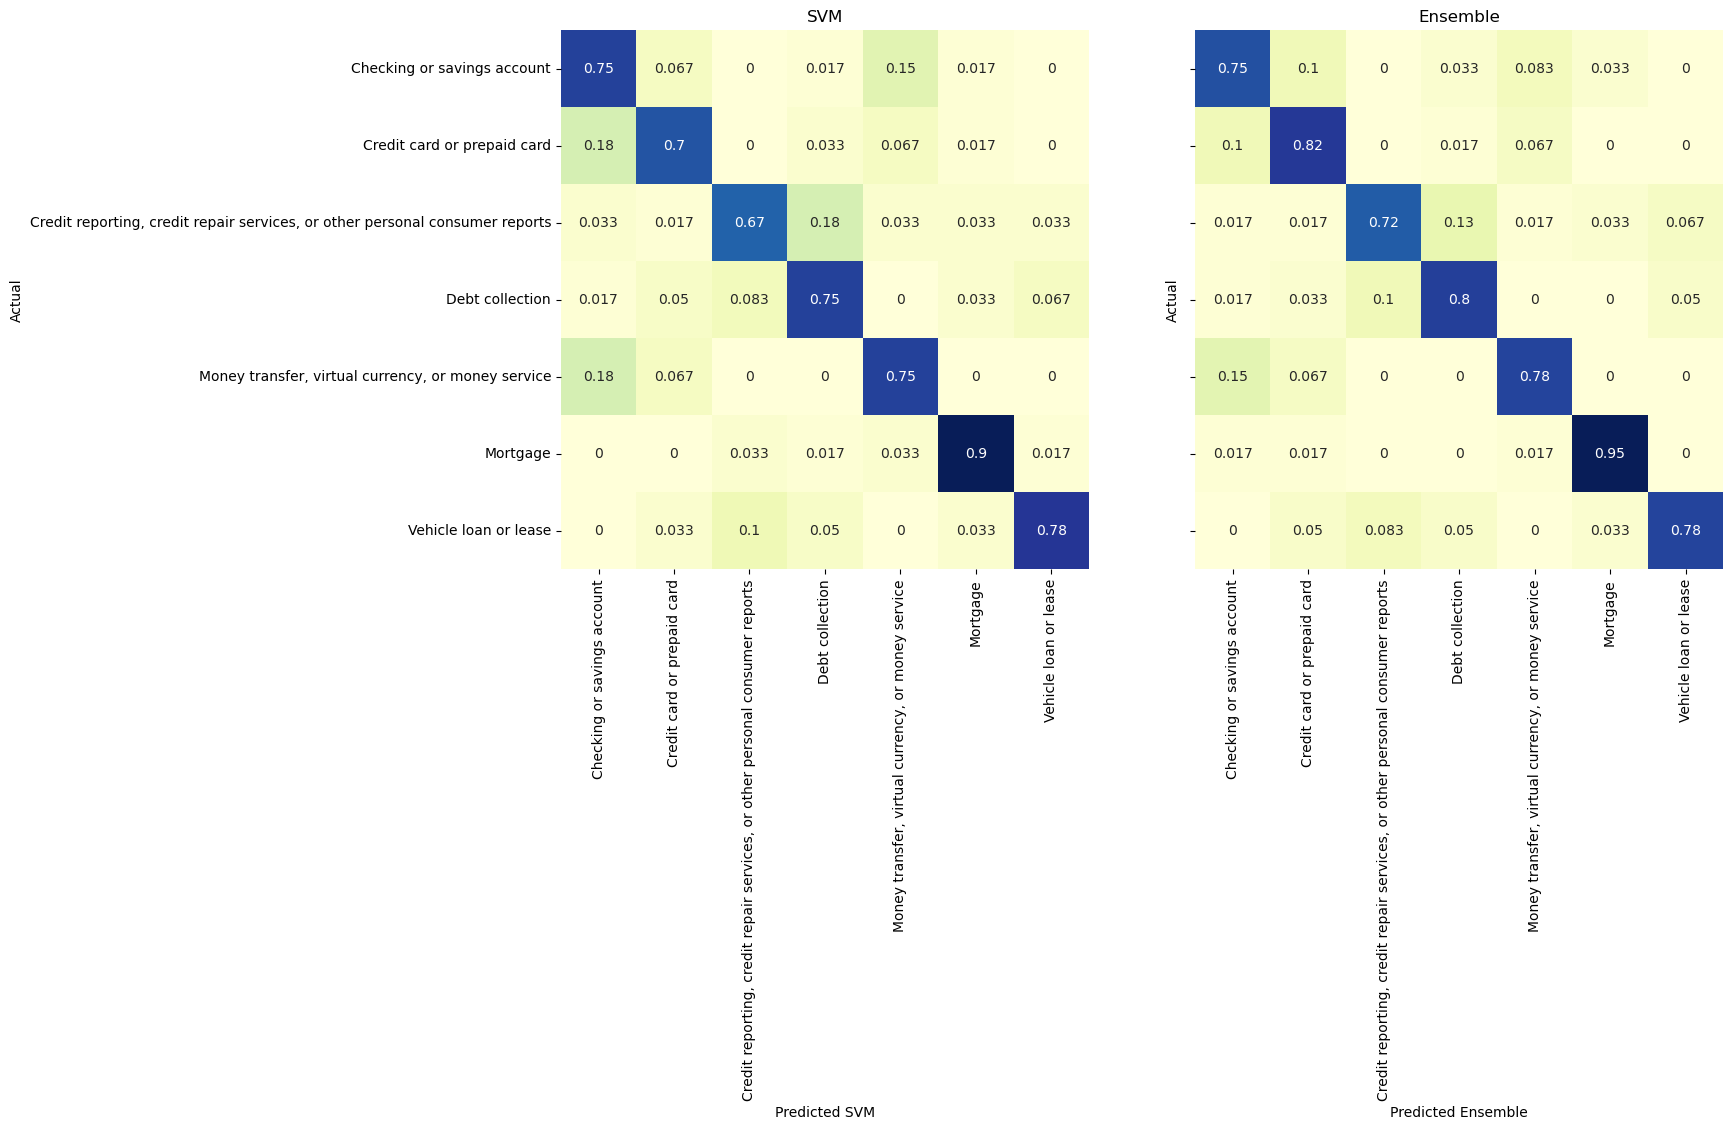

In [34]:
SVM_confusion_df = pd.crosstab(result_df['Product'], result_df['Predicted SVM'], rownames=['Actual'], normalize='index')
ensemble_confusion_df = pd.crosstab(result_df['Product'], result_df['Predicted Ensemble'], rownames=['Actual'], normalize='index')

figure, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,7))

sn.heatmap(SVM_confusion_df, annot=True, cmap="YlGnBu", ax=ax1, cbar=False)
sn.heatmap(ensemble_confusion_df, annot=True, cmap="YlGnBu", ax=ax2, cbar=False)
ax1.title.set_text("SVM")
ax2.title.set_text("Ensemble")
ax2.set_yticklabels([])

plt.show()

#### Findings

In the confusion matrix for the SVM model you can now see that complaints for `Credit reporting, credit repair services, or other personal consumer reports` are often misclassified as `Debt collection` - and vice versa. Other common misclassifications can be gathered from the table.

Overall, the ensemble model performs better than the SVM model. However, the SVM model had a significantly shorter training time. 

In subsequent steps, consider increasing the size of the training data, tuning the CNN training parameters or adjusting the  weights of the ensemble model to gain better results.

<a id="summary"></a>
## Summary

This notebook shows you how to use the Watson NLP library and how quickly and easily you can train and run different text classifiers using Watson NLP.

### Authors
Simone Zerfass IBM, Germany

Alexander Lang IBM, Germany

# <hr>
Copyright © 2021 IBM. This notebook and its source code are released under the terms of the MIT License.